In [7]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

import controller as con

## Load the model and create MjData and Renderer objects to go along with it

$\texttt{model}$ contains all information about the robot/environment; this includes all parts, links, joints, and the ground.

$\texttt{data}$ contains all information about the state of $\texttt{model}$. We can read information about the environment's state here, and apply forces at joints. This is where all the physics modeling takes place.

$\texttt{renderer}$ contains all necessary information to render the scene.

In [8]:
# simulation environment
model = mujoco.MjModel.from_binary_path("Quadruped MJB.mjb")
data = mujoco.MjData(model)

# visualization
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.distance = 3
camera.trackbodyid = 2
camera.azimuth = 30

# misc options
model.opt.gravity = (0, 0, -9.81)

## Define functions for running the robot's controllers

$\texttt{update\_controller()}$ reads state information about the environment, inputs it to the controller, runs the controller, and applies the controller outputs to the robot's joints.

$$ \texttt{data.qpos} = [body , body , body , body , body , body , fr\_hip , fr\_knee , fl\_hip , fl\_knee , rr\_hip , rr\_knee , rl\_hip , rl\_knee] $$

In [14]:
# create the controller objects
fr_leg = con.leg_controller
fl_leg = con.leg_controller
rr_leg = con.leg_controller
rl_leg = con.leg_controller

def update_controller(model,data):
    pos_offsets = np.array([0,0,0,0,0,0,.736600934,-1.51121634,-.737159549,-1.51177616,-.736600879,-1.51121629,.737164507,-1.51177608])
    pos_directions = np.array([1,1,1,1,1,1,1,1,-1,1,-1,1,1,1])

    current_pos = -np.multiply(data.qpos[1:],pos_directions) - pos_offsets
    current_vel = data.qvel


    target_pos_absolute = np.array([0,0,0,0,0,0,-1.05/2,1.05,-1.05/2,1.05,-1.05/2,1.05,-1.05/2,1.05])
    target_pos = np.multiply(target_pos_absolute,pos_directions) + pos_offsets
    joint_pos = data.qpos
    joint_vel = data.qvel
    errors = target_pos - joint_pos[1:]

    kp = 10
    kd = .5
    p_gains = np.array([0,0,0,0,0,0,kp,kp,kp,kp,kp,kp,kp,kp])
    d_gains = np.array([0,0,0,0,0,0,kd,kd,kd,kd,kd,kd,kd,kd])
    forces = errors * p_gains - joint_vel * d_gains

    data.qfrc_applied[:14] = forces

update_controller(model,data)

None


Simulate and render the simulation

In [10]:
duration = 5  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
n_frames = int(duration/.002 + 1)
frames = []
positions = np.zeros((n_frames,model.nv+1))
time = np.zeros(n_frames)
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
for i in range(n_frames):
  # step the simulator
  mujoco.mj_step(model, data)

  # apply forces
  update_controller(model,data)

  # store any data we need stored
  positions[i] = data.qpos
  time[i] = data.time
  i = i+ 1

  # render the scene if we're at the correct timestep to have a frame
  if len(frames) < data.time * framerate:
    #camera.azimuth = data.time*75
    renderer.update_scene(data,camera)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

Plot Recorded Data

[-2.51734951e-05  2.39915495e-02  2.54147577e-01  9.99990309e-01
 -4.40235472e-03 -3.36251347e-05  2.84637550e-05  2.35195804e-01
 -3.75978682e-01 -2.35927745e-01 -3.76425489e-01 -2.46791169e-01
 -3.45081232e-01  2.47235154e-01 -3.45523102e-01]


Text(0.5, 1.0, 'Joint Positions')

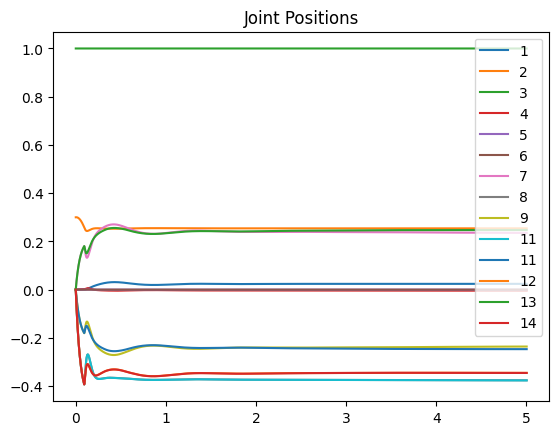

In [11]:
print(data.qpos)
plt.plot(time,np.array(positions[:,1]),label='1')
plt.plot(time,np.array(positions[:,2]),label='2')
plt.plot(time,np.array(positions[:,3]),label='3')
plt.plot(time,np.array(positions[:,4]),label='4')
plt.plot(time,np.array(positions[:,5]),label='5')
plt.plot(time,np.array(positions[:,6]),label='6')
plt.plot(time,np.array(positions[:,7]),label='7')
plt.plot(time,np.array(positions[:,8]),label='8')
plt.plot(time,np.array(positions[:,9]),label='9')
plt.plot(time,np.array(positions[:,10]),label='11')
plt.plot(time,np.array(positions[:,11]),label='11')
plt.plot(time,np.array(positions[:,12]),label='12')
plt.plot(time,np.array(positions[:,13]),label='13')
plt.plot(time,np.array(positions[:,14]),label='14')
plt.legend()
plt.title("Joint Positions")
#plt.ylim([-2,2])

Time The Functions

In [12]:
del time
import time

c = con.leg_controller()

th1 = np.pi/4
th2 = -2*th1
x = 5
y = 5

t = time.time()
c.cartesian_to_joint(np.array([th1,th2]),x,y)
t_inv = time.time() - t

t = time.time()
c.joint_to_cartesian(th1,th2)
t_for = time.time() - t

t = time.time()
# call bezier function
t_bez = time.time() - t

t = time.time()
# call flight controller
t_flight = time.time() - t

t = time.time()
# call stance controller
t_stance = time.time() - t

print(f"Function Execution Times: \n\n\rInverse Kinematics: {t_inv} \n\rForward Kinematics: {t_for} \n\rBezier Generation: {t_bez} \n\rFlight Controller: {t_flight} \n\rStance Controller: {t_stance}")

Function Execution Times: 

Inverse Kinematics: 0.0003020763397216797 
Forward Kinematics: 5.555152893066406e-05 
Bezier Generation: 1.9550323486328125e-05 
Flight Controller: 1.811981201171875e-05 
Stance Controller: 1.6927719116210938e-05
